In [77]:
import requests
import inspect
import pytz
import pandas as pd
import numpy as np

from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import (YEARLY, DateFormatter,rrulewrapper, RRuleLocator, drange)
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from time import ctime   # ctime converts epoch time (ex:1661522400) to string form (Thu Aug 25 16:00:00 2022)
from time import gmtime   # Convert a time expressed in seconds since the epoch to a struct_time in UTC in which the dst flag is always zero.
from time import localtime # Like gmtime() but converts to local time.

from datetime import datetime, timedelta
today = datetime.now()
import datetime as dt

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 20




### 2 fichiers créés par node-red et mis à jour toutes les heures avec openweather node dans onglet Temp/Hum

#### json_file ="C:/Users/jean/OneDrive/Bureau/5days.txt"

#### json_file ="Y:/Documents/5days.txt"

#### le fichier contient une liste de 40 lignes :
- une ligne = 3 heures, 
- 8 lignes par jour 
- sur 5 jours


In [78]:
try:
    json_file = "Y:/Documents/5days.txt"  # pc cuisine
    current = pd.read_json(json_file)
except:
    json_file = "Z:/Documents/5days.txt"  # pc chambre
    current = pd.read_json(json_file)

In [79]:
#current['dates'] = [datetime.fromtimestamp(current.dt[k], pytz.timezone('Europe/Paris')) for k in range(40)]
current['dates'] = [datetime.fromtimestamp(current.dt[k]) for k in range(40)]
current['h_date'] = [datetime.fromtimestamp(current.dt[k]).strftime('%d/%m/%Y %H:%M:%S') for k in range(40)]
current['h_time'] = [datetime.fromtimestamp(current.dt[k]).strftime('%H') for k in range(40)]
current.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   temp        40 non-null     float64       
 1   feels_like  40 non-null     float64       
 2   temp_min    40 non-null     float64       
 3   temp_max    40 non-null     float64       
 4   pressure    40 non-null     int64         
 5   sea_level   40 non-null     int64         
 6   grnd_level  40 non-null     int64         
 7   humidity    40 non-null     int64         
 8   temp_kf     40 non-null     float64       
 9   dt          40 non-null     int64         
 10  dates       40 non-null     datetime64[ns]
 11  h_date      40 non-null     object        
 12  h_time      40 non-null     object        
dtypes: datetime64[ns](1), float64(5), int64(5), object(2)
memory usage: 4.2+ KB


In [80]:
debut = current.head(1).h_date[0]
fin = current.tail(1).h_date[39]
debut, fin

('30/07/2024 14:00:00', '04/08/2024 11:00:00')

<Axes: >

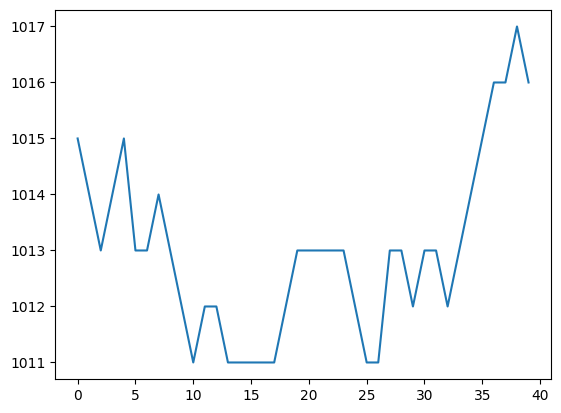

In [81]:
current.pressure.plot()


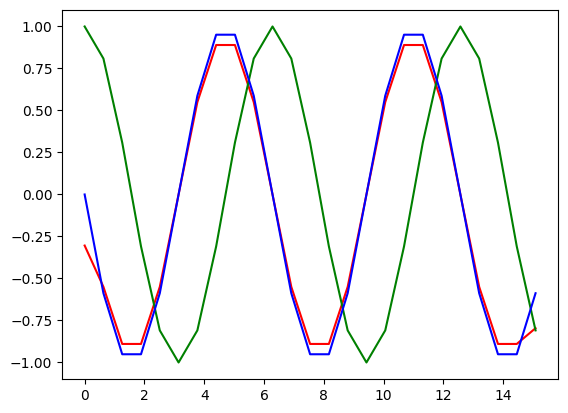

In [82]:
pi = np.pi
x = np.arange(0,5*pi,0.2*pi)
y = np.cos(x) 
# derivative dy/dx = -sin(x)
der = np.gradient(y,x)
plt.plot(x, der, 'r', x, y, 'g', x, -np.sin(x),'b')
plt.show()

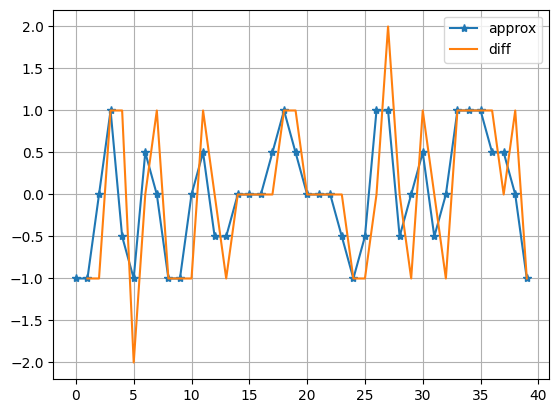

In [83]:
# derivative of pressure
dy = current.pressure#.diff()
#dy.plot()
# we sample a sin(x) function
dx = current.index.step
x = np.arange(0,40)
#current.pressure.diff().plot(label='diff')
# we calculate the derivative, with np.gradient
plt.plot(x,np.gradient(dy, dx), '-*', label='approx')
#plt.plot()
dy.diff().plot(x=x,label='diff')
plt.legend()
plt.grid()


<Axes: >

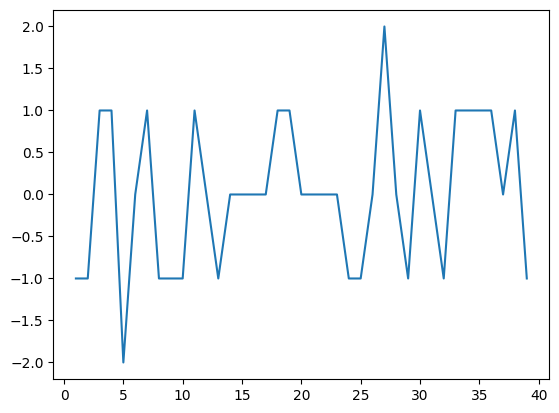

In [84]:
dy.diff().plot()

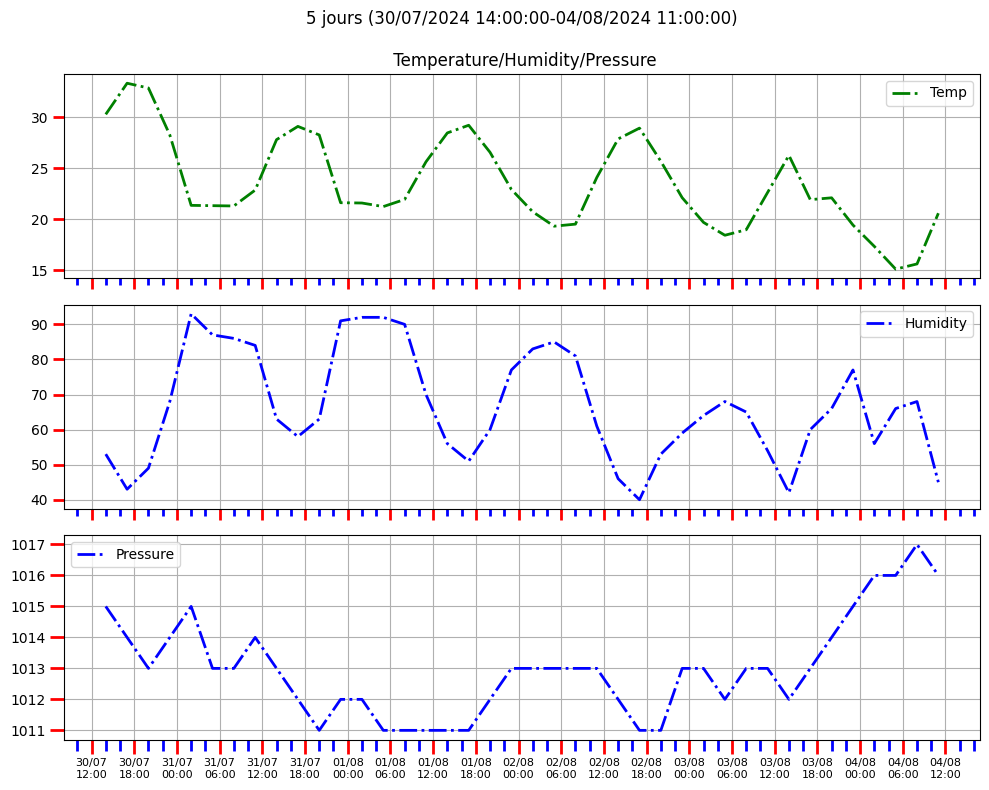

In [85]:
#fig, (ax1,ax2,ax3) = plt.subplots(3,1)
fig, (ax1,ax2,ax3) = plt.subplots(3, sharex=True)
# the size of A4 paper
fig.set_size_inches(10, 8)

ax1.tick_params('x', labelsize=8)
ax2.tick_params('x', labelsize=8)
ax3.tick_params('x', labelsize=8)

# format affichage dates sur axe des x
formatter = DateFormatter('%d/%m\n%H:%M')
#ax1.xaxis.set_major_formatter(formatter)
#ax2.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_formatter(formatter)

# nombre de ticks sur axe des x
major_ticks = 1/4                    # toutes les 6 heures pour 1/4, 12h pour 1/2
minor_ticks = major_ticks/3          # facteur div = 4  -> minor ticks toutes les 3 heures

# temperature
ax1.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax1.xaxis.set_minor_locator(MultipleLocator(minor_ticks))  # ???? pas d'affichage des minor ticks ???
# format des ticks
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=8, color='r')
ax1.tick_params(which='minor', length=5, color='b')
#plot
ax1.plot(current.dates,current.temp,'g-.',label='Temp',linewidth=2)
#plt.plot(current.dates,current.temp_max,'r-.',label='Max',linewidth=2)
#plt.plot(current.dates,current.temp_min,'b-.',label='Min',linewidth=2)

# humidity
ax2.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax2.xaxis.set_minor_locator(MultipleLocator(minor_ticks))  
# format des ticks
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=8, color='r')
ax2.tick_params(which='minor', length=5, color='b')
ax2.plot(current.dates,current.humidity,'b-.',label='Humidity',linewidth=2)

# pression
ax3.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax3.xaxis.set_minor_locator(MultipleLocator(minor_ticks))  
# format des ticks
ax3.tick_params(which='both', width=2)
ax3.tick_params(which='major', length=10, color='r')
ax3.tick_params(which='minor', length=8, color='b')
ax3.plot(current.dates,current.pressure,'b-.',label='Pressure',linewidth=2)

ax1.grid()
ax1.legend()
ax2.grid()
ax2.legend()
ax3.grid()
ax3.legend()

ax1.set_title(f'5 jours ({debut}-{fin})\n\n Temperature/Humidity/Pressure')
#ax2.set_title(f'Humidity')
fig.tight_layout()


# tendances

## temp * pression / humidity
- plus de pression, moins d'humidité = meilleure tendance

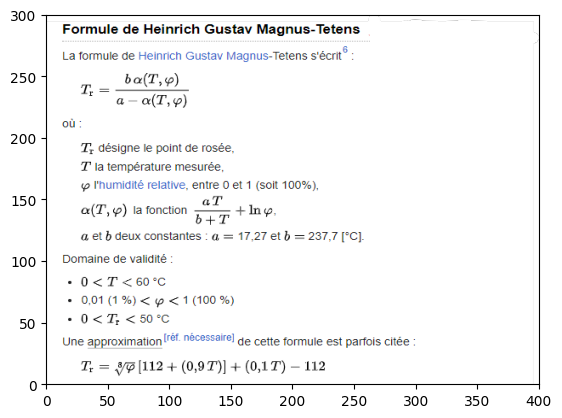

In [86]:
img = plt.imread(r"C:\Users\jean\Pictures\Screenshots\Screenshot 2024-06-04 095520.png")    # don't work with svg files
fig, ax = plt.subplots()
x = range(300)
ax.imshow(img, extent=[0, 400, 0, 300])

Le point de rosée est une donnée thermodynamique caractérisant l'humidité dans un gaz. 
Le point de rosée de l'air est la température à laquelle la pression partielle de vapeur 
d'eau est égale à sa pression de vapeur saturante. Il s'agit donc de la température à 
laquelle il faut refroidir un volume d'air, à pression et humidité absolue constantes, 
pour qu'il devienne saturé donc il y a condensation.

La dépression du point de rosée est la différence entre la température et le point de rosée : (T-Tr)
 à un niveau de pression donnée de l'atmosphère terrestre

 https://fr.wikipedia.org/wiki/Point_de_ros%C3%A9e


La dépression du point de rosée est la différence entre la température et le point de rosée (T-Tr) à un niveau de pression donnée de l'atmosphère terrestre7. Plus cette valeur est petite, plus l’humidité relative à cette altitude est grande et plus la présence de nuages est probable. Ainsi, une dépression de plus de 5 °C est en général associée avec l'absence de couche nuageuse et une valeur près de 0 °C est synonyme d'une couverture complète. La variation dans la troposphère de la dépression du point de rosée, analysée sur un diagramme thermodynamique comme un téphigramme, permet de connaître la hauteur, l'épaisseur et l'étendue des couches nuageuses sur une région.

Text(0.5, 1.0, 'Point de rosée')

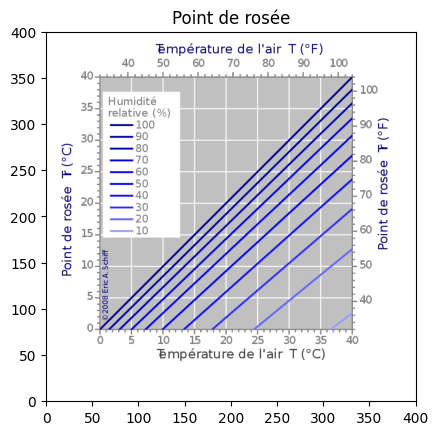

In [87]:
img = plt.imread(r"C:\Users\jean\Pictures\1024px-Dewpoint-RH-fr.svg.png")    # don't work with svg files
fig, ax = plt.subplots()
x = range(300)
ax.imshow(img, extent=[0, 400, 0, 400])
plt.title('Point de rosée')

# si on a hum=80% à la temp=10°C, point de rosée = 7°C, depression = 10-7 = 3 < 5 (nuages)
# si on a hum=70% à la temp=10°C, point de rosée = 5°C, depression = 10-5 = 5 (clair)

In [88]:
import numpy as np
a, b = 17.27, 237.7

def alpha(T,phi):
    '''
    0 < T < 60
    0.01 < phi < 1
    '''
    return a*T/(b+T) + np.log(phi)

def dewpoint(T, phi): # phi : humidité relative
    f = alpha(T,phi)
    Tr = b*f/(a-f)
    return (T,Tr,T-Tr) #round(Tr,2), round(T-Tr,2)   # dewpoint, depression


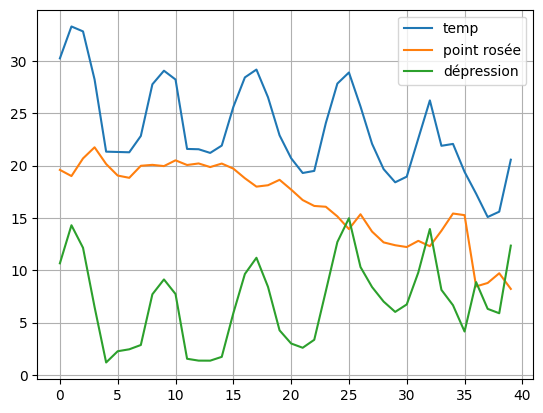

In [89]:
x = np.arange(40)
x_temp = current.temp
x_hum = current.humidity/100

rosee = dewpoint(x_temp,x_hum)
plt.plot(x,x_temp,label='temp')
plt.plot(x,rosee[1],label='point rosée')
plt.plot(x,rosee[2],label='dépression')
plt.grid()
plt.legend()


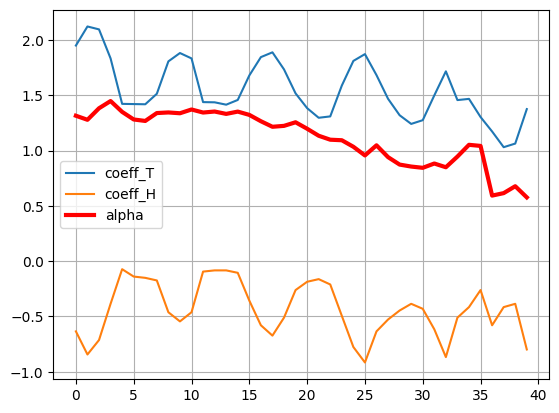

In [90]:
# alpha(temp,hum)
y_temp = a*x_temp/(b+x_temp)
y_hum = np.log(x_hum)
plt.plot(x,y_temp,label='coeff_T')
plt.plot(x,y_hum,label='coeff_H')  # valeurs négatives
f = y_temp+y_hum  # alpha() = y_temp + y_hum
plt.plot(x,f,label='alpha',lw=3,c='red')
plt.grid()
plt.legend()


(237.7, 17.27)

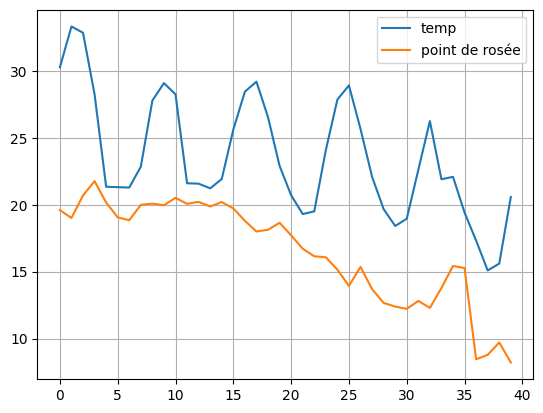

In [91]:
# point de rosée
plt.plot(x,x_temp,label='temp')
plt.plot(x,b*f/(a-f),label='point de rosée')
plt.grid()
plt.legend()
b,a


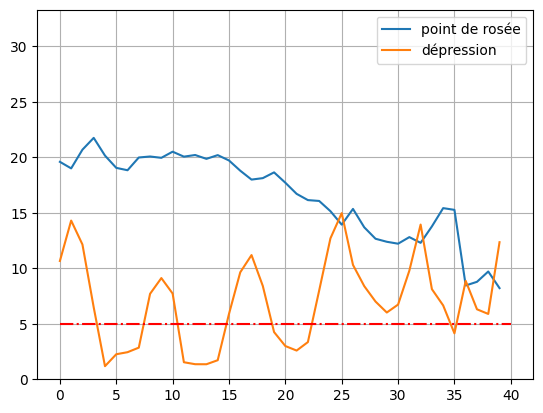

In [92]:
plt.plot(x,b*f/(a-f),label='point de rosée')
plt.plot(x,x_temp - b*f/(a-f),label='dépression')
plt.plot((0,40),(5,5),'r-.')  # si depression < 5, risuqe de nuages et pluie
plt.grid()
plt.ylim(0,max(x_temp))
plt.legend()

In [93]:
# alpha
f = y_temp+y_hum
f, alpha(x_temp,x_hum)


(0     1.315376
 1     1.278696
 2     1.383001
 3     1.448228
 4     1.350151
         ...   
 35    1.042399
 36    0.593095
 37    0.615397
 38    0.677946
 39    0.576967
 Length: 40, dtype: float64,
 0     1.315376
 1     1.278696
 2     1.383001
 3     1.448228
 4     1.350151
         ...   
 35    1.042399
 36    0.593095
 37    0.615397
 38    0.677946
 39    0.576967
 Length: 40, dtype: float64)

In [94]:
(x,y_hum)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 0    -0.634878
 1    -0.843970
 2    -0.713350
 3    -0.385662
 4    -0.072571
         ...   
 35   -0.261365
 36   -0.579818
 37   -0.415515
 38   -0.385662
 39   -0.798508
 Name: humidity, Length: 40, dtype: float64)

In [95]:
dewpoint(current.temp[0],current.humidity[0]/100)

(30.26, 19.597136088273828, 10.662863911726173)

In [96]:
dewpt = dewpoint(current.temp ,current.humidity/100) 
dewpt[1] # point de rosée

0     19.597136
1     19.006956
2     20.692351
3     21.757598
4     20.159165
        ...    
35    15.268938
36     8.453528
37     8.783146
38     9.712344
39     8.215709
Length: 40, dtype: float64

In [97]:
dewpt[2]   # dépression

0     10.662864
1     14.303044
2     12.147649
3      6.482402
4      1.180835
        ...    
35     4.141062
36     8.866472
37     6.306854
38     5.887656
39    12.354291
Length: 40, dtype: float64

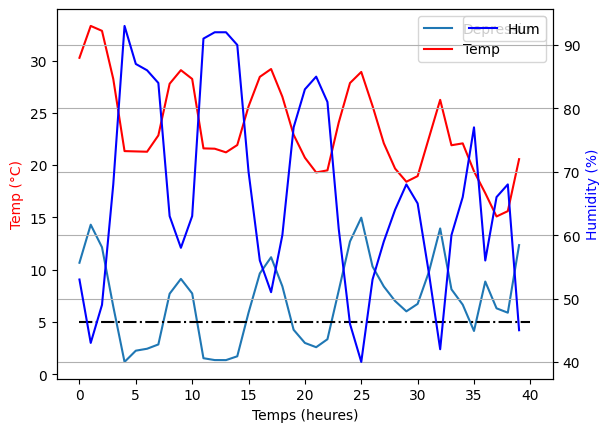

In [98]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(dewpt[2],label='Depression')
ax1.plot(current.temp,'r',label='Temp')
ax2.plot(current.humidity,'b',label='Hum')
ax1.plot((0,40),(5,5),'k-.')  # black
#plt.ylim(min(dewpt[2])-2,max(current.temp)+2)
ax1.set_xlabel('Temps (heures)')
ax1.set_ylabel('Temp (°C)', color='r')
ax2.set_ylabel('Humidity (%)', color='b')
ax1.legend()
ax2.legend()
plt.grid()
plt.show()


In [99]:
current.temp.head(),current.h_time.head()

(0    30.26
 1    33.31
 2    32.84
 3    28.24
 4    21.34
 Name: temp, dtype: float64,
 0    14
 1    17
 2    20
 3    23
 4    02
 Name: h_time, dtype: object)

In [100]:
current['dew_point'] = dewpt[1]
current[['h_time','temp','dew_point']]

,h_time,temp,dew_point
0,14,30.26,19.597136
1,17,33.31,19.006956
2,20,32.84,20.692351
3,23,28.24,21.757598
4,02,21.34,20.159165
...,...,...,...
35,23,19.41,15.268938
36,02,17.32,8.453528
37,05,15.09,8.783146
38,08,15.60,9.712344


In [101]:
current.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   temp        40 non-null     float64       
 1   feels_like  40 non-null     float64       
 2   temp_min    40 non-null     float64       
 3   temp_max    40 non-null     float64       
 4   pressure    40 non-null     int64         
 5   sea_level   40 non-null     int64         
 6   grnd_level  40 non-null     int64         
 7   humidity    40 non-null     int64         
 8   temp_kf     40 non-null     float64       
 9   dt          40 non-null     int64         
 10  dates       40 non-null     datetime64[ns]
 11  h_date      40 non-null     object        
 12  h_time      40 non-null     object        
 13  dew_point   40 non-null     float64       
dtypes: datetime64[ns](1), float64(6), int64(5), object(2)
memory usage: 4.5+ KB


In [102]:
current.dates

0    2024-07-30 14:00:00
1    2024-07-30 17:00:00
2    2024-07-30 20:00:00
3    2024-07-30 23:00:00
4    2024-07-31 02:00:00
             ...        
35   2024-08-03 23:00:00
36   2024-08-04 02:00:00
37   2024-08-04 05:00:00
38   2024-08-04 08:00:00
39   2024-08-04 11:00:00
Name: dates, Length: 40, dtype: datetime64[ns]

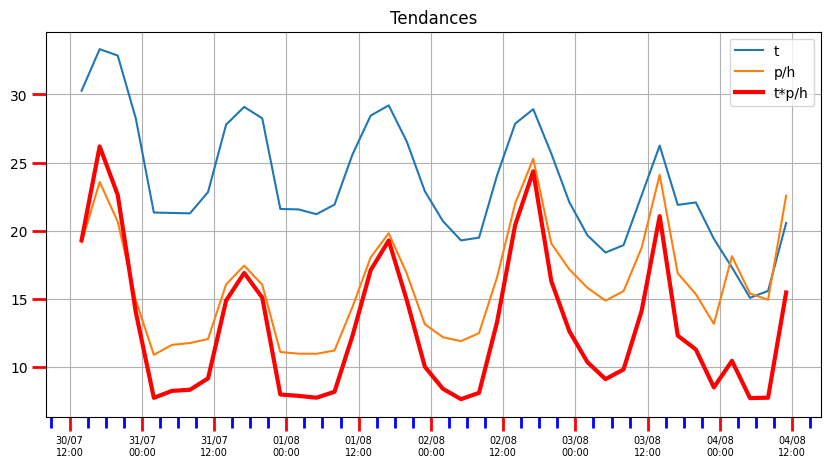

In [103]:
result1=current.temp  #*current.humidity*current.pressure
result2=(current.pressure)/(current.humidity*10)  #p/h est normalisé, on ramène le rapport autour de 1
result3=(current.temp)*result2

fig, ax = plt.subplots()

# nombre de ticks sur axe des x
major_ticks = 1/2                   # toutes les 6 heures pour 1/4, 12h pour 1/2, 3 heures pour 1/8
minor_ticks = major_ticks/4          # denominateur n = n minor ticks 


# format grid
fig.set_size_inches(10, 5)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
ax.tick_params('x', labelsize=7)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10, color='r')
ax.tick_params(which='minor', length=8, color='b')

# plot
plt.plot(current.dates, result1,label='t')
plt.plot(current.dates, result2*10,label='p/h')
plt.plot(current.dates, result3/3,label='t*p/h',lw=3,c='red')
plt.legend()
plt.title('Tendances')
plt.grid()

<Axes: >

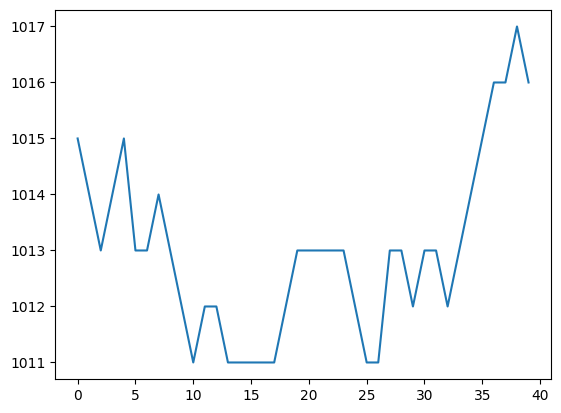

In [104]:
current.pressure.plot()

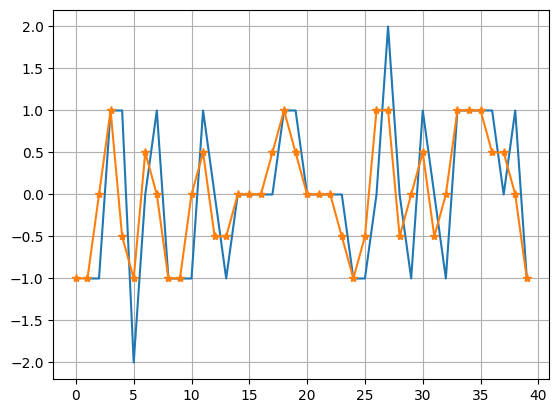

In [105]:
dy.diff().plot()
plt.plot(x,np.gradient(dy, dx), '-*', label='approx')
plt.grid()

In [106]:
len(dy)

40

In [107]:
current.dates

0    2024-07-30 14:00:00
1    2024-07-30 17:00:00
2    2024-07-30 20:00:00
3    2024-07-30 23:00:00
4    2024-07-31 02:00:00
             ...        
35   2024-08-03 23:00:00
36   2024-08-04 02:00:00
37   2024-08-04 05:00:00
38   2024-08-04 08:00:00
39   2024-08-04 11:00:00
Name: dates, Length: 40, dtype: datetime64[ns]

Text(0.5, 1.0, 'Températures sur 5 jours')

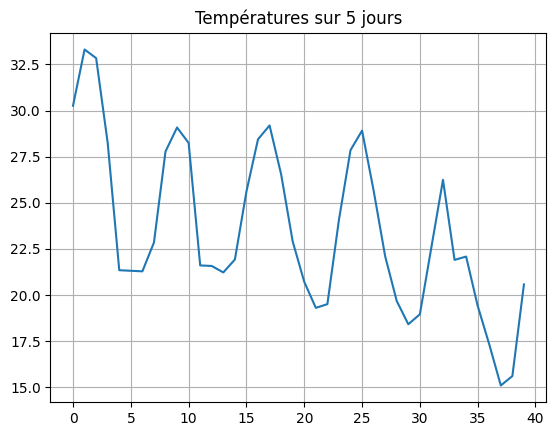

In [108]:
temp = current.temp 
temp.plot(grid=True)
plt.title('Températures sur 5 jours')

<Axes: >

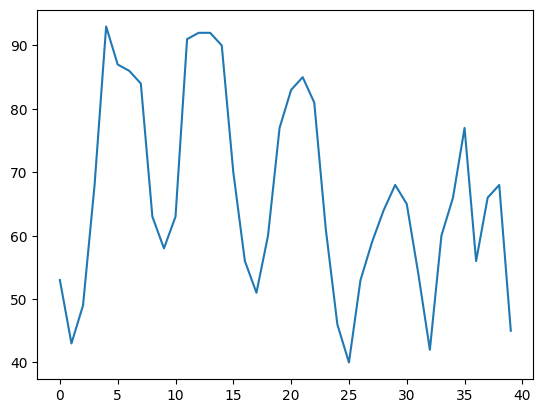

In [109]:
current.humidity.plot()

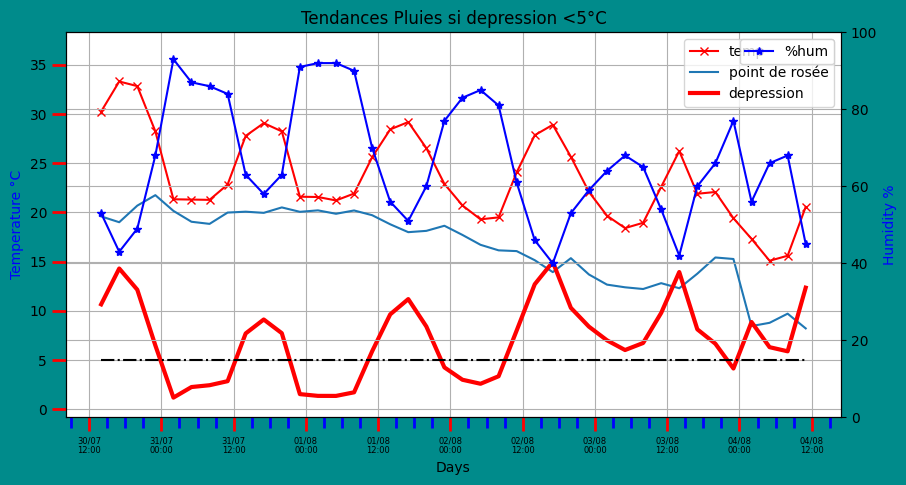

In [110]:
# point de rosée
current['dewpoint']=dewpt[1]
point_rosee = dewpt[1]
# calcul de la dépression
depression = current.temp-point_rosee
current['depression']=depression
fig, ax1 = plt.subplots(facecolor='darkcyan')
ax2 = ax1.twinx()
ax1.set_xlabel('Days')
ax1.set_ylabel('Temperature °C', color='b')
ax2.set_ylabel('Humidity %', color='b')
# format grid
fig.set_size_inches(10, 5)
# graduations axeX
ax1.xaxis.set_major_formatter(formatter)
ax1.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax1.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
ax1.tick_params('x', labelsize=6)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=10, color='r')
ax1.tick_params(which='minor', length=8, color='b')

# plot
ax1.plot(current.dates, temp,'x-',label='temp',color='r')
ax2.plot(current.dates, current.humidity,'*-',label='%hum',color='blue')
ax1.plot(current.dates, point_rosee,label='point de rosée')#,lw=3,c='red')
# tendances pluie
#lbl = 'depr<5+ "pluie" if depression[0]<5 else ""
ax1.plot(current.dates, depression,label="depression",lw=3,c='red')
#ax1.plot(current.dates, depression+dy.diff(),'-.',label="depression+diffpressure",lw=2,c='blue')
ax1.plot((current.dates[0],current.dates[39]),(5,5),'-.',color='black') 

# https://stackoverflow.com/questions/28095852/set-ylim-on-subplot-secondary-y-axis
ax1.set_ylim(min(depression)-2,max(current.temp)+5)
ax2.set_ylim(0, 100)
ax1.legend()
ax2.legend()
plt.title('Tendances Pluies si depression <5°C')
ax1.grid()
ax2.grid()

In [111]:
datetime.now().strftime('%d/%m/%Y %H:%M:%S')

'30/07/2024 11:33:10'

In [112]:
current['tendances']=current['depression'].apply(lambda x: 'pluie' if x<5 else 'beau temps')
# 24 h
current[:20][['h_date','temp','depression','tendances']]

,h_date,temp,depression,tendances
0,30/07/2024 14:00:00,30.26,10.662864,beau temps
1,30/07/2024 17:00:00,33.31,14.303044,beau temps
2,30/07/2024 20:00:00,32.84,12.147649,beau temps
3,30/07/2024 23:00:00,28.24,6.482402,beau temps
4,31/07/2024 02:00:00,21.34,1.180835,pluie
5,31/07/2024 05:00:00,21.31,2.256031,pluie
6,31/07/2024 08:00:00,21.28,2.440987,pluie
7,31/07/2024 11:00:00,22.84,2.851532,pluie
8,31/07/2024 14:00:00,27.78,7.702481,beau temps
9,31/07/2024 17:00:00,29.08,9.121277,beau temps


In [113]:
current[20:40][['h_date','temp','depression','tendances']]

,h_date,temp,depression,tendances
20,02/08/2024 02:00:00,20.71,2.995812,pluie
21,02/08/2024 05:00:00,19.30,2.588524,pluie
22,02/08/2024 08:00:00,19.50,3.351444,pluie
23,02/08/2024 11:00:00,24.07,7.998858,beau temps
24,02/08/2024 14:00:00,27.85,12.701158,beau temps
25,02/08/2024 17:00:00,28.91,14.974753,beau temps
26,02/08/2024 20:00:00,25.66,10.306954,beau temps
27,02/08/2024 23:00:00,22.09,8.394412,beau temps
28,03/08/2024 02:00:00,19.67,7.005254,beau temps
29,03/08/2024 05:00:00,18.41,6.017459,beau temps


In [114]:
current.h_date

0     30/07/2024 14:00:00
1     30/07/2024 17:00:00
2     30/07/2024 20:00:00
3     30/07/2024 23:00:00
4     31/07/2024 02:00:00
             ...         
35    03/08/2024 23:00:00
36    04/08/2024 02:00:00
37    04/08/2024 05:00:00
38    04/08/2024 08:00:00
39    04/08/2024 11:00:00
Name: h_date, Length: 40, dtype: object